In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Uninstall packages from Kaggle base image that are not needed.
!pip uninstall -qy jupyterlab jupyterlab-lsp
# Install the google-genai SDK for this codelab.
!pip install -qU 'google-genai==1.7.0'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 4.3 MB/s eta 0:00:00


In [2]:
from google import genai
from google.genai import types

from IPython.display import Markdown, HTML, display

genai.__version__

'1.7.0'

In [4]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

In [5]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

In [6]:
# Ask for information without search grounding.
response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents="When and where is Billie Eilish's next concert?")

Markdown(response.text)

Unfortunately, I cannot provide you with specific dates and locations for Billie Eilish's future concerts in real-time. Concert schedules are constantly changing, and I do not have access to this up-to-the-minute information.

However, here are some places you can find reliable and up-to-date concert information:

*   **Billie Eilish's Official Website:** This is the best place to start. Look for a "Tour" or "Events" section.
*   **Ticketmaster or other major ticketing sites:** These sites will list concert dates and venues as soon as they are announced.
*   **Live Nation:** This is a large concert promoter, and they often announce tour dates.
*   **Music News Websites and Blogs:** Follow reputable music news outlets; they will often report on tour announcements.
*   **Social Media:** Follow Billie Eilish on her official social media accounts.

Good luck finding a show near you!

In [7]:
# And now re-run the same query with search grounding enabled.
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

def query_with_grounding():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents="When and where is Billie Eilish's next concert?",
        config=config_with_search,
    )
    return response.candidates[0]


rc = query_with_grounding()
Markdown(rc.content.parts[0].text)

Billie Eilish's next concert is on **April 23, 2025**, at the **Avicii Arena** in **Stockholm, Sweden.**


In [8]:
while not rc.grounding_metadata.grounding_supports or not rc.grounding_metadata.grounding_chunks:
    # If incomplete grounding data was returned, retry.
    rc = query_with_grounding()

chunks = rc.grounding_metadata.grounding_chunks
for chunk in chunks:
    print(f'{chunk.web.title}: {chunk.web.uri}')

vividseats.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKAyIwfOEBl_IEOfkbCLY8hCo_Xw4EXCxO4qwotaoZNfrKWpoNL2nzAUHE45pUCIErT66KCRZqvVrBmuOvEml9ejp7nHmG6tU9V9mpSNeVyDl8cOZEMdm7NKiC2UPEmG459ijuDrQrvZG8EAsOOlRpwurv3I1iZFMIyqQ==
ticketmaster.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIvz3gzkmdjAvKVe1hbgAxCoFPtc-S7PMw2q5t8gZ-7cHvhxjPWFiIZuVmRmfMAwcjjUJRUFBItGl5EaktHD1mZT7yG0WNxQ317rRoh04pQjC_d6_vKe_kJhoZxyE-v5tZ9Def-44gZueFr5uv9Nt5kEsRGQv7iMjuaq-Y=
ticketmaster.co.uk: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJStiBKQy9HBb_vK0VI7bHgg3xYWo5AjjjpoY6xur2hRy3AuuV5EnHQbOa03jkl1ufTDs7XfstFVEbvPE8ADlC0KzUwMBvSy9OHd_3Ys871mT3cYcohWdajZXvLcnq5zcHMMcBddNtkGfQVRd7_azptuBnQlv5U97EEuwgmfg==


In [9]:
HTML(rc.grounding_metadata.search_entry_point.rendered_content)

In [10]:
from pprint import pprint

supports = rc.grounding_metadata.grounding_supports
for support in supports:
    pprint(support.to_json_dict())

{'confidence_scores': [0.60748243, 0.6063901, 0.6169501],
 'grounding_chunk_indices': [0, 1, 2],
 'segment': {'end_index': 104,
             'text': "Billie Eilish's next concert is on **April 23, 2025**, "
                     'at the **Avicii Arena** in **Stockholm, Sweden.**'}}


In [11]:
import io

markdown_buffer = io.StringIO()

# Print the text with footnote markers.
markdown_buffer.write("Supported text:\n\n")
for support in supports:
    markdown_buffer.write(" * ")
    markdown_buffer.write(
        rc.content.parts[0].text[support.segment.start_index : support.segment.end_index]
    )

    for i in support.grounding_chunk_indices:
        chunk = chunks[i].web
        markdown_buffer.write(f"<sup>[{i+1}]</sup>")

    markdown_buffer.write("\n\n")
# And print the footnotes.
markdown_buffer.write("Citations:\n\n")
for i, chunk in enumerate(chunks, start=1):
    markdown_buffer.write(f"{i}. [{chunk.web.title}]({chunk.web.uri})\n")


Markdown(markdown_buffer.getvalue())

Supported text:

 * Billie Eilish's next concert is on **April 23, 2025**, at the **Avicii Arena** in **Stockholm, Sweden.**<sup>[1]</sup><sup>[2]</sup><sup>[3]</sup>

Citations:

1. [vividseats.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKAyIwfOEBl_IEOfkbCLY8hCo_Xw4EXCxO4qwotaoZNfrKWpoNL2nzAUHE45pUCIErT66KCRZqvVrBmuOvEml9ejp7nHmG6tU9V9mpSNeVyDl8cOZEMdm7NKiC2UPEmG459ijuDrQrvZG8EAsOOlRpwurv3I1iZFMIyqQ==)
2. [ticketmaster.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIvz3gzkmdjAvKVe1hbgAxCoFPtc-S7PMw2q5t8gZ-7cHvhxjPWFiIZuVmRmfMAwcjjUJRUFBItGl5EaktHD1mZT7yG0WNxQ317rRoh04pQjC_d6_vKe_kJhoZxyE-v5tZ9Def-44gZueFr5uv9Nt5kEsRGQv7iMjuaq-Y=)
3. [ticketmaster.co.uk](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJStiBKQy9HBb_vK0VI7bHgg3xYWo5AjjjpoY6xur2hRy3AuuV5EnHQbOa03jkl1ufTDs7XfstFVEbvPE8ADlC0KzUwMBvSy9OHd_3Ys871mT3cYcohWdajZXvLcnq5zcHMMcBddNtkGfQVRd7_azptuBnQlv5U97EEuwgmfg==)


In [12]:
from IPython.display import display, Image, Markdown

def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())
    
        display(Markdown('----'))

In [13]:
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
    temperature=0.0,
)

chat = client.chats.create(model='gemini-2.0-flash')

response = chat.send_message(
    message="What were the medal tallies, by top-10 countries, for the 2024 olympics?",
    config=config_with_search,
)

show_response(response)

Here's the medal tally for the top 10 countries at the 2024 Paris Olympics:

1.  **United States:** 40 Gold, 44 Silver, 42 Bronze (126 total)
2.  **China:** 40 Gold, 27 Silver, 24 Bronze (91 total)
3.  **Japan:** 20 Gold, 12 Silver, 13 Bronze (45 total)
4.  **Australia:** 18 Gold, 19 Silver, 16 Bronze (53 total)
5.  **France:** 16 Gold, 26 Silver, 22 Bronze (64 total)
6.  **Netherlands:** 15 Gold, 7 Silver, 12 Bronze (34 total)
7.  **Great Britain:** 14 Gold, 22 Silver, 29 Bronze (65 total)
8.  **Republic of Korea:** 13 Gold, 9 Silver, 10 Bronze (32 total)
9.  **Italy:** 12 Gold, 13 Silver, 15 Bronze (40 total)
10. **Germany:** 12 Gold, 13 Silver, 8 Bronze (33 total)

----

Okay, I can help you visualize this data using a Seaborn chart. I'll use a python code block to create the chart.



----

{'executable_code': {'code': "import pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Data for the medal tally\ndata = {\n    'Country': ['United States', 'China', 'Japan', 'Australia', 'France', 'Netherlands', 'Great Britain', 'Republic of Korea', 'Italy', 'Germany'],\n    'Gold': [40, 40, 20, 18, 16, 15, 14, 13, 12, 12],\n    'Silver': [44, 27, 12, 19, 26, 7, 22, 9, 13, 13],\n    'Bronze': [42, 24, 13, 16, 22, 12, 29, 10, 15, 8]\n}\n\n# Create a Pandas DataFrame\ndf = pd.DataFrame(data)\n\n# Melt the DataFrame to long format for Seaborn\ndf_melted = pd.melt(df, id_vars='Country', var_name='Medal', value_name='Count')\n\n# Create the bar plot\nplt.figure(figsize=(12, 8))  # Adjust figure size for better readability\nsns.barplot(x='Country', y='Count', hue='Medal', data=df_melted, palette={'Gold': 'gold', 'Silver': 'silver', 'Bronze': 'brown'})\nplt.title('2024 Olympics Medal Tally (Top 10 Countries)')\nplt.xlabel('Country')\nplt.ylabel('Medal Count')\nplt.xtic

----

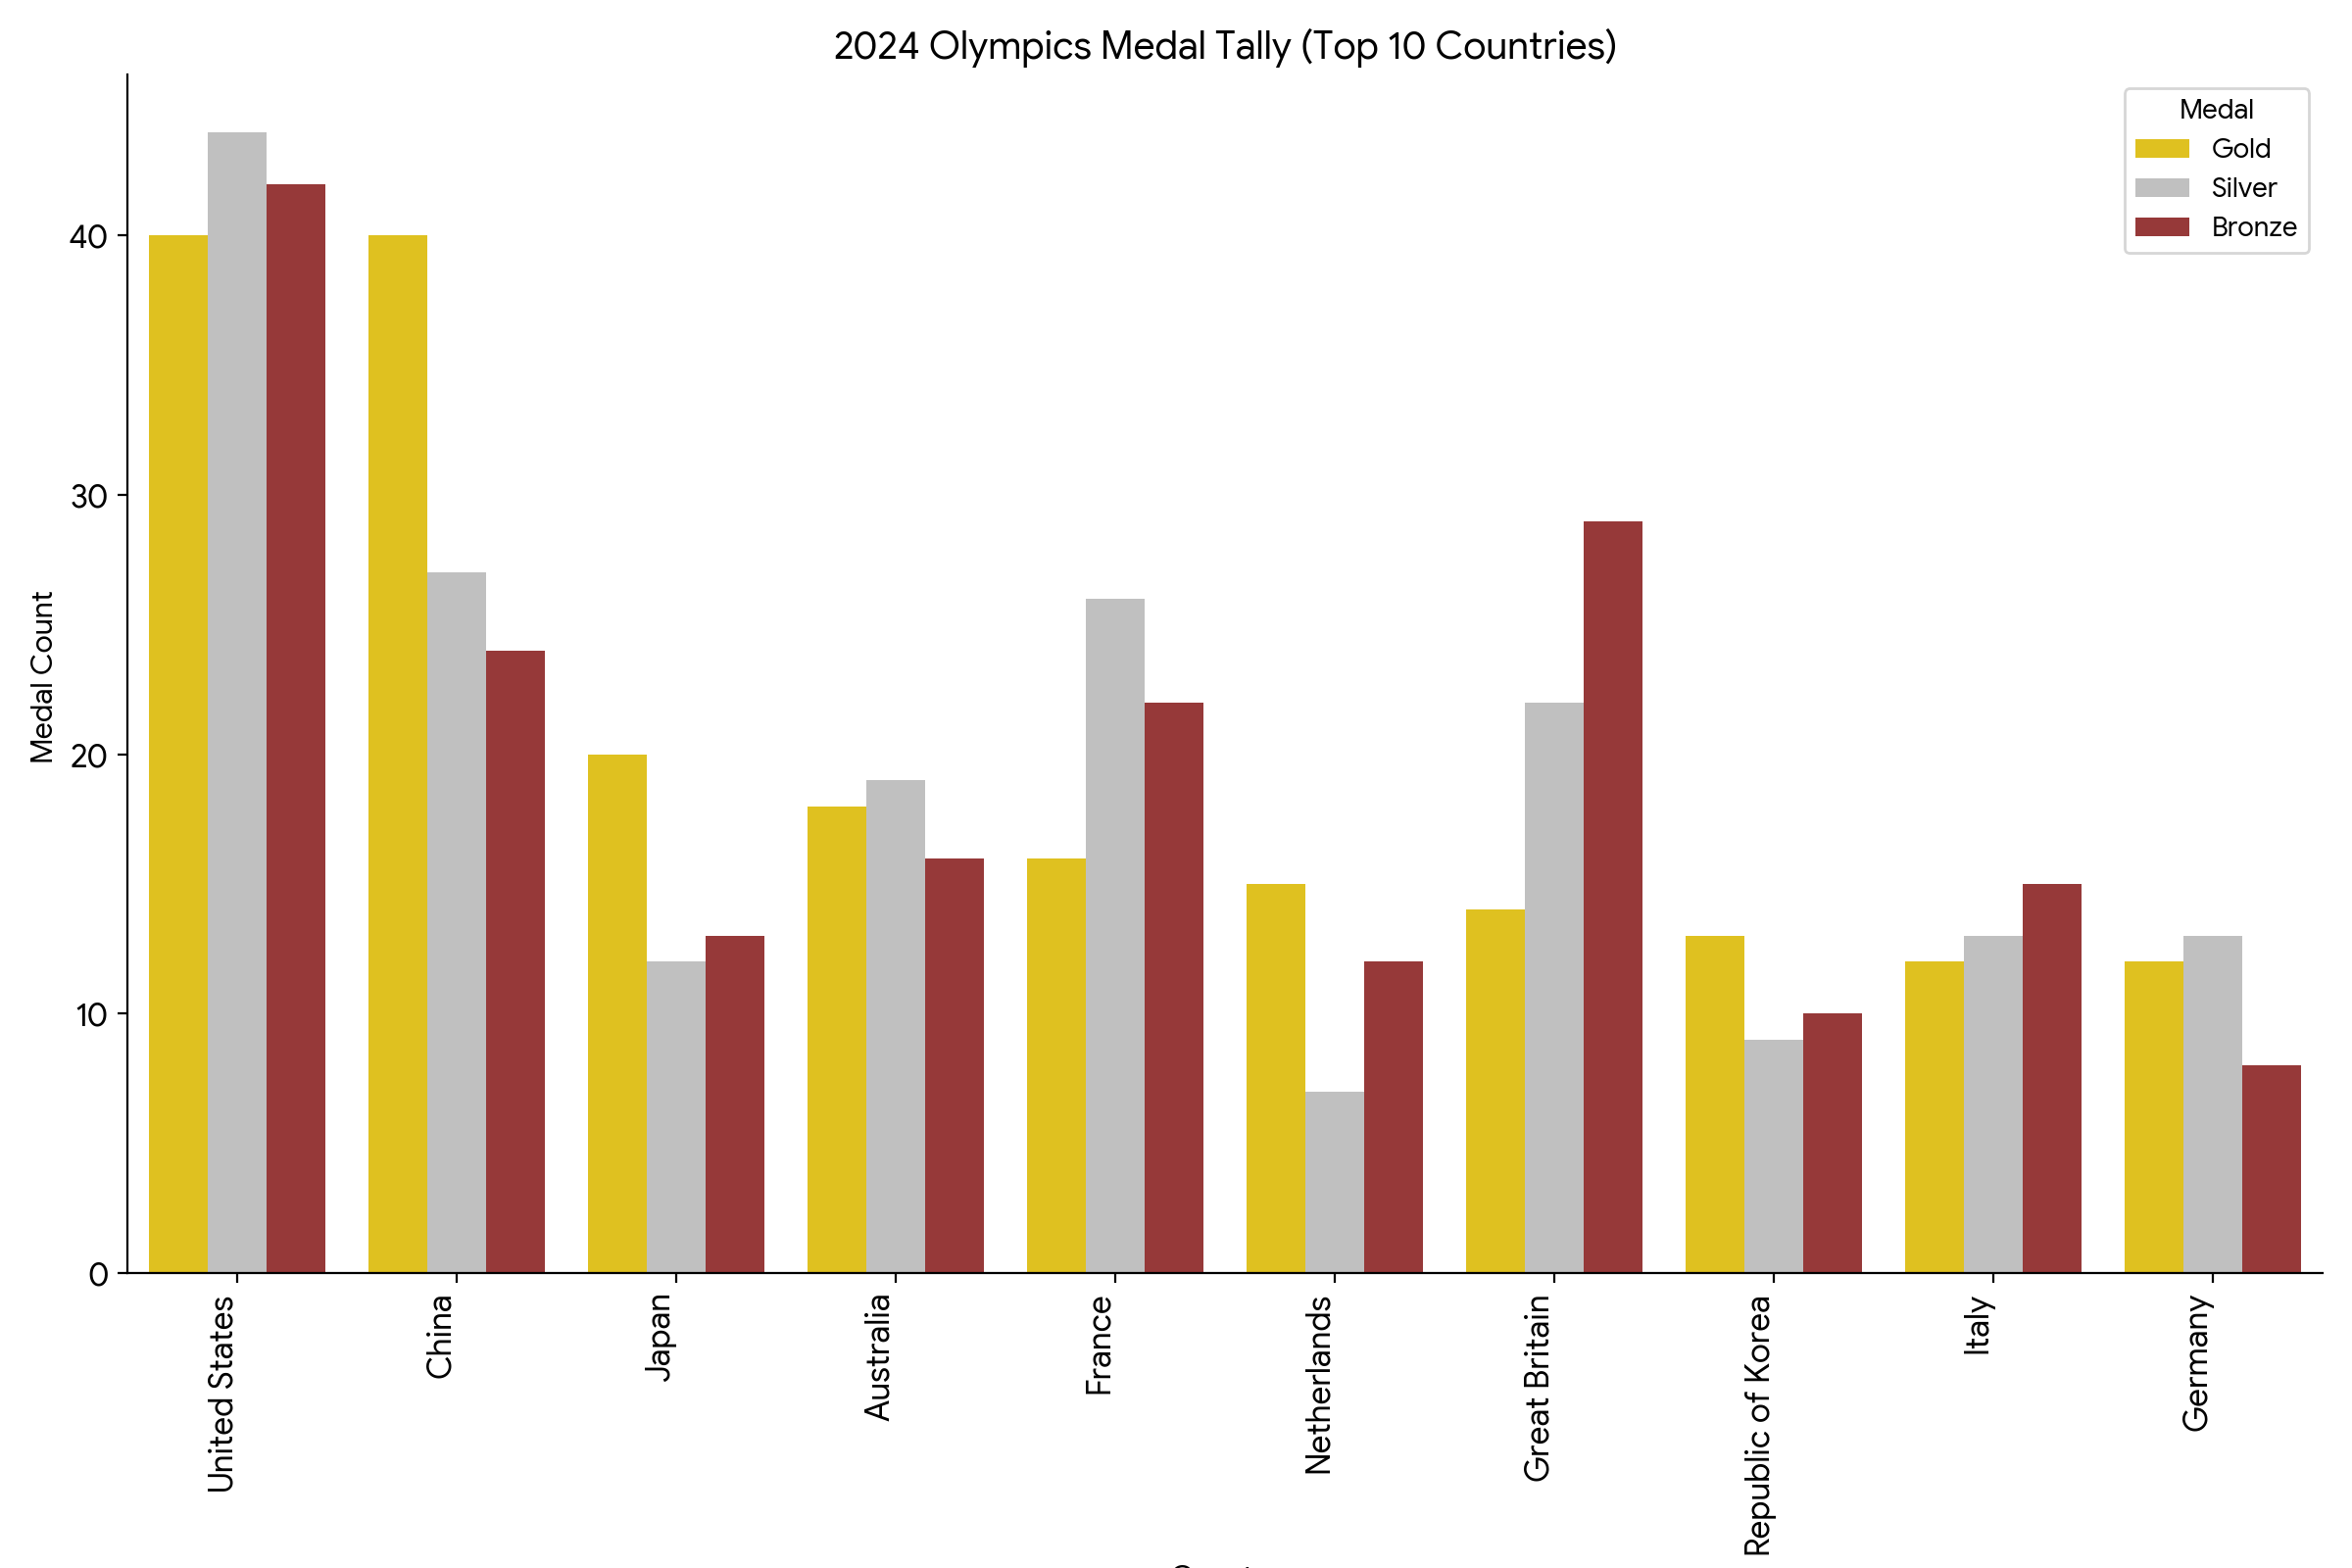

----

The code produced the bar chart as requested. The chart displays the medal counts (Gold, Silver, and Bronze) for the top 10 countries in the 2024 Olympics. The x-axis represents the countries, and the y-axis represents the medal count. Different colors represent the different medal types (Gold, Silver, and Bronze). The x-axis labels are rotated for better readability.


----

In [14]:
config_with_code = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
    temperature=0.0,
)

response = chat.send_message(
    message="Now plot this as a seaborn chart. Break out the medals too.",
    config=config_with_code,
)

show_response(response)